In [29]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
import matplotlib.path as pth

In [43]:
class StackGeometry:
    """
    A class representing the geometry of a stack of hexagonal lattice structures.
    Contains functions to build up fibre design and convert to desired stack structure.

    Attributes:
    -----------
    nRings : int
        Number of hexagonal rings in the lattice structure
    corePitch : float
        Distance between adjacent cores in the lattice structure
    latticePoints : list
        List of lattice points in the hexagonal lattice
    coreLocations : list
        List of lattice points in the hexagonal lattice
    airholeCoords : list
        List of air hole coordinates
    clickPositions : list
        List of mouse click positions

    Methods:
    --------
    build_triangular_lattice():
        Builds a triangular lattice for the hexagonal lattice structure
    trim_lattice_to_fibre():
        Trims the triangular lattice to fit inside the hexagonal fibre
    add_cores_from_file(filepath: str):
        Reads a CSV file containing core locations and adds the core locations to the coreLocations attribute
    on_click(event):
        Appends the mouse click positions to the clickPositions attribute
    select_cores_with_mouse():
        Allows user to select core locations using mouse clicks
    make_cores_from_selection():
        Makes core locations from selected positions
    add_pcf_airholes(d_over_lambda: float):
        Adds air holes for all lattice points in the hexagonal lattice structure
    show_fibre_design():
        Plots the fibre design using Matplotlib
    choose_jacket_tube(jacket_od: int, jacket_id: int)
        Select tube for jacketing cane, outer and inner diameter in microns
    choose_stack_tube(stack_od: int, stack_id: int)
        Select tube for stack, outer and inner diameter in microns
    scale_lattice_to_stack_size()
        scales up fibre sizes using given jacket and stack tube to make a stack diagram
    show_stack_design()
        plots stack diagram
    """
    def __init__(self, number_of_rings, pitch):
        self.nRings = number_of_rings
        self.corePitch = pitch
        self.latticePoints = []
        self.coreLocations = []
        self.airholeCoords = []
        self.clickPositions = []

    def build_triangular_lattice(self):
        # Loop through all lattice points in a triangular pattern
        for i in range(2*self.nRings +1):
            for j in range(2*self.nRings +1):
                x = j * self.corePitch
                y = i * self.corePitch * 0.8660254  # 0.8660254 is the sine of 60 degrees
                
                # Shift every other row of lattice points
                if i % 2 == 1:
                    x += self.corePitch / 2
                    
                # Append the lattice point to the list of points
                self.latticePoints.append((x, y))
        
        # Shift the lattice points so that the center is at the origin
        if self.nRings % 2 == 1:
            self.latticePoints = np.array(self.latticePoints) - np.array([self.nRings*self.corePitch +  self.corePitch / 2, self.nRings* self.corePitch * 0.8660254 ])
        else:
            self.latticePoints = np.array(self.latticePoints) - np.array([self.nRings*self.corePitch, self.nRings* self.corePitch * 0.8660254 ])

    def trim_lattice_to_fibre(self):
        # Calculate maximum x and y coordinates for the hexagon bounding the lattice points
        max_xr = (self.nRings)*self.corePitch 
        max_yr = (self.nRings+1)*self.corePitch * 0.8660254 - 0.001
        
        # Define the vertices of the hexagon
        hexagon_coord_x = np.array([max_xr, max_xr/2 , -max_xr/2, -max_xr, -max_xr/2, max_xr/2, max_xr])
        hexagon_coord_y = np.array([0, max_yr, max_yr, 0, -max_yr, -max_yr, 0])
        
        # Create a path object that represents the hexagon
        hexagon_poly_points = list(zip(hexagon_coord_x, hexagon_coord_y))
        hexagon_path = pth.Path(hexagon_poly_points)
        
        # Remove lattice points outside the hexagon
        self.latticePoints = self.latticePoints[hexagon_path.contains_points(self.latticePoints)]
        
        # Find the lattice points that are too far from the center of the hexagon
        points_to_keep = np.where(cdist(self.latticePoints, np.array([[0,0]]), 'euclidean')<self.nRings*self.corePitch-0.00001 , False, True)
        
        # Remove the lattice points that are too far from the center of the hexagon
        index_to_keep = np.invert(np.any(points_to_keep, axis=1))
        self.latticePoints = self.latticePoints[index_to_keep]


    def add_cores_from_file(self, filepath):
        # Read in *.csv file with coords in the following form:
        #% Model	|honeycomb finite realistic design.mph   |
        #% Version	|COMSOL 6.0.0.405                        |    
        #% Date	    |Apr 3 2023, 15:29                       |
        #% Table	|Table 10 - Point Evaluation 3           |    
        #    x	    |     y                                  |   
        #  -25.143	|  -2.561703144                          |
        #   ...     |    ...                                 |   

        coord_data = pd.read_csv(filepath, skiprows=4) # skip 4 lines of COMSOL preamble
        self.coreLocations = np.stack([coord_data['x'].to_numpy(),coord_data['y'].to_numpy()], axis=1)
    
    def on_click(self, event):
        self.clickPositions.append([event.xdata,event.ydata])

    def select_cores_with_mouse(self):
        fig_cores = plt.figure(figsize=(6,6))
        ax_cores = fig_cores.add_subplot(111)
        ax_cores.scatter(self.latticePoints[:,0], self.latticePoints[:,1])
        fig_cores.canvas.mpl_connect('button_press_event', self.on_click)
        plt.show()

    def make_cores_from_selection(self):
        pos = np.array(self.clickPositions)
        points_to_keep = np.where(cdist(self.latticePoints, pos, 'euclidean')>2, False, True)
        self.coreLocations = self.latticePoints[np.any(points_to_keep, axis=1)]
        
    def add_pcf_airholes(self, d_over_lambda):
        # add main air holes for all lattice points 
        self.airholeCoords = self.latticePoints
        self.pcfDOverLambda = d_over_lambda

    def show_fibre_design(self):
        # Define a function to plot the fibre design using Matplotlib
        fig_circ = plt.figure(figsize=(9,5))
        axcirc = fig_circ.add_subplot(111)

        # Set the outer diameter of the fibre to be the core pitch distance
        outer_circ = self.corePitch
        core_circ_list = []
        outer_circ_list = []


        # Create a list of circles at each lattice point to represent the outer diameter of the fibre
        for _point in self.latticePoints:
            outer_circ_list.append(patches.Circle(_point, radius=outer_circ/2, ec='black'))

        # Create a list of circles at each core location to represent the core of the fibre
        for _point in self.coreLocations:
            core_circ_list.append(patches.Circle(_point, radius=outer_circ/2, ec='black', fc='red'))

        # Add the circles to the plot
        for _circ in outer_circ_list:
            axcirc.add_patch(_circ)

        # optionally add airholes if making pcf
        if len(self.airholeCoords) != 0:
            for _point in self.airholeCoords:
                axcirc.add_patch(patches.Circle(_point, radius=self.pcfDOverLambda*outer_circ/2, fc='white', ec='black'))
        
        # add red circles for cores 
        for _circ in core_circ_list:
            axcirc.add_patch(_circ)

        # Set the axis to be scaled and show the plot
        plt.axis('scaled')
        plt.show()

    def choose_jacket_tube(self, jacket_od, jacket_id):
        # Define a function to set the outer and inner diameters of the jacket tube
        # Use microns for all sizes
        self.jacketId = jacket_id
        self.jacketOd = jacket_od

    def choose_stack_tube(self, stack_od, stack_id):
        # Define a function to set the outer and inner diameters of the stack tube
        # Use microns for all sizes
        self.stackId = stack_id
        self.stackOd = stack_od 

        # Calculate the required capillary diameter based on the number of rings
        self.capillaryDiameter = float(self.stackId)*0.99/(2*self.nRings)
        print('Capillary Diameter Required: {}'.format(self.capillaryDiameter))

    def scale_lattice_to_stack_size(self):
        # Define a function to scale the lattice points and core locations to the size of the stack
        scale_factor_stack_to_cane = self.jacketId/self.stackOd
        scale_factor_cap_to_pitch = self.corePitch/self.capillaryDiameter
        scale_factor_cane_to_fib = scale_factor_cap_to_pitch/scale_factor_stack_to_cane

        # Print the required fibre diameter
        print('Required Fibre Diamter: {}'.format(self.jacketOd*scale_factor_cane_to_fib))

        # Scale the core locations and lattice points
        self.stackCoreLocations = self.coreLocations/scale_factor_cap_to_pitch
        self.stackLatticePoints = self.latticePoints/scale_factor_cap_to_pitch
        if len(self.airholeCoords) != 0:
            self.airholeCoords = self.airholeCoords/scale_factor_cap_to_pitch


    def show_stack_design(self):
        # Create a new figure with a size of 9 inches by 5 inches
        fig_circ = plt.figure(figsize=(9,5))
        # Add a subplot to the figure
        axcirc = fig_circ.add_subplot(111)

        # Create empty lists for circles representing the stack fibers and jacket
        stack_core_circ_list = []
        stack_outer_circ_list = []
        
        # Add a black circle representing the outer diameter of the jacket
        axcirc.add_patch(patches.Circle((0, 0), radius=self.stackOd/2, ec='black'))
        # Add a white circle representing the inner diameter of the jacket
        axcirc.add_patch(patches.Circle((0, 0), radius=self.stackId/2, color='white', ec='black'))

        # Loop through the lattice points of the stack fibers and add circles to the list
        for _point in self.stackLatticePoints:
            stack_outer_circ_list.append(patches.Circle(_point, radius=self.capillaryDiameter/2, ec='black'))

        # Loop through the core locations of the stack fibers and add circles to the list
        for _point in self.stackCoreLocations:
            stack_core_circ_list.append(patches.Circle(_point, radius=self.capillaryDiameter/2, ec='black', fc='red'))
            
        # Add the circles for the stack fibers to the plot
        for _circ in stack_outer_circ_list:
            axcirc.add_patch(_circ)

        # optionally add airholes if making pcf
        if len(self.airholeCoords) != 0:
            for _point in self.airholeCoords:
                axcirc.add_patch(patches.Circle(_point, radius=self.pcfDOverLambda*self.capillaryDiameter/2, fc='white', ec='black'))

        # Add the circles for the core locations of the stack fibers to the plot
        for _circ in stack_core_circ_list:
            axcirc.add_patch(_circ)

        # Set the aspect ratio of the plot to 'equal'
        plt.axis('scaled')
        # Show the plot
        plt.show()


In [44]:
core_file_path = '../COMSOL/Data/Honeycomb/realistic honeycomb coords.csv'
core_to_core_pitch = 2.958 # ensre this is the same as the pitch used in comsol

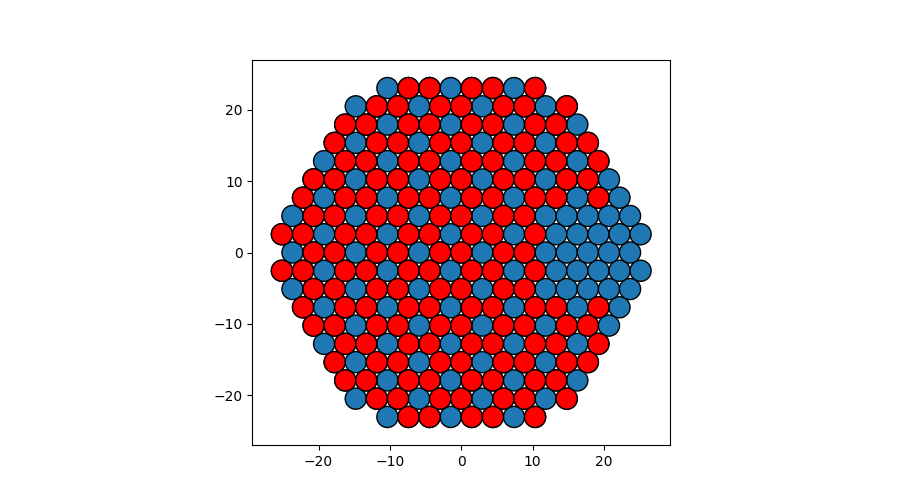

In [45]:
solidStack = StackGeometry(9, core_to_core_pitch)
solidStack.build_triangular_lattice()
solidStack.trim_lattice_to_fibre()
solidStack.add_cores_from_file(core_file_path) 
solidStack.show_fibre_design()

Capillary Diameter Required: 1045.0
Required Fibre Diamter: 202.18728639781273


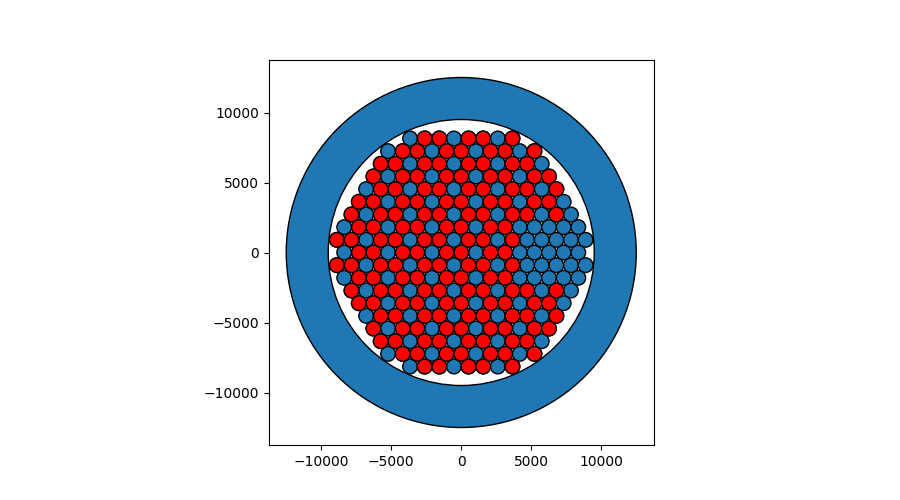

In [46]:
solidStack.choose_jacket_tube(10_000,3_500)
solidStack.choose_stack_tube(25_000, 19_000)
solidStack.scale_lattice_to_stack_size()
solidStack.show_stack_design()

## Photonic Crystal Fibre with manually selected cores

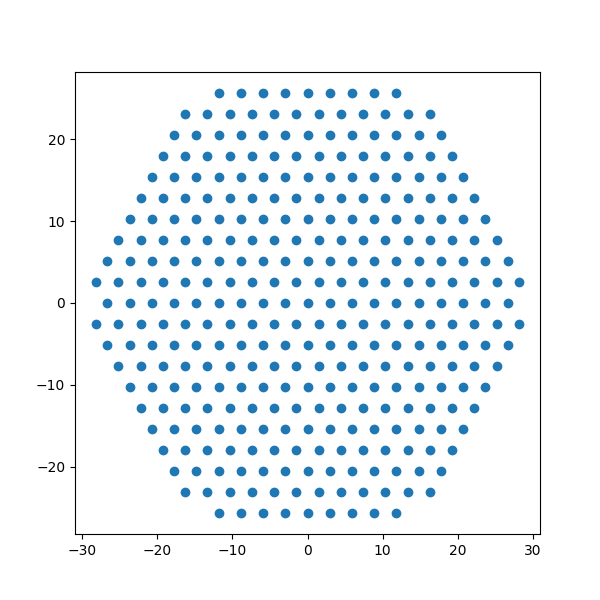

In [40]:
pcfStack = StackGeometry(10, 2.958)
pcfStack.build_triangular_lattice()
pcfStack.trim_lattice_to_fibre()
# pcfStack.add_cores_from_file(core_file_path)
# pcfStack.add_pcf_airholes(0.5)
# pcfStack.show_fibre_design()
pcfStack.select_cores_with_mouse()

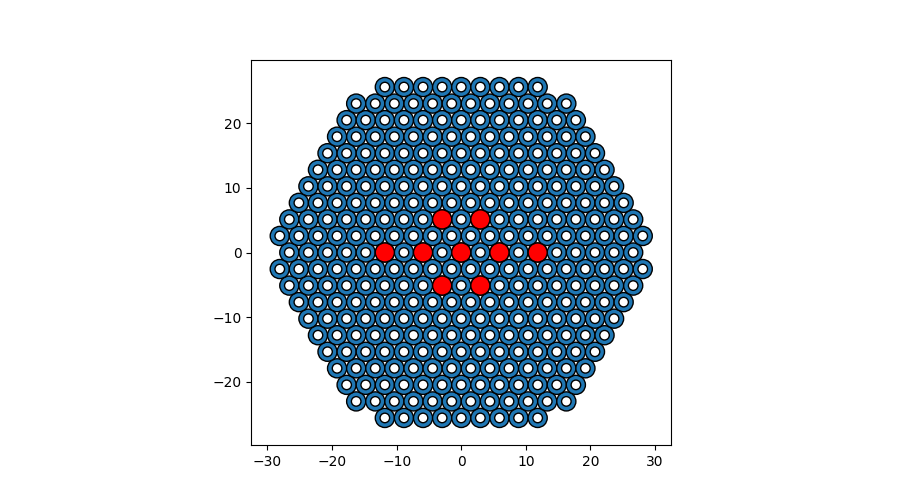

In [27]:
pcfStack.make_cores_from_selection()
pcfStack.add_pcf_airholes(0.5)
pcfStack.show_fibre_design()


Capillary Diameter Required: 950.0
Required Fibre Diamter: 222.406015037594


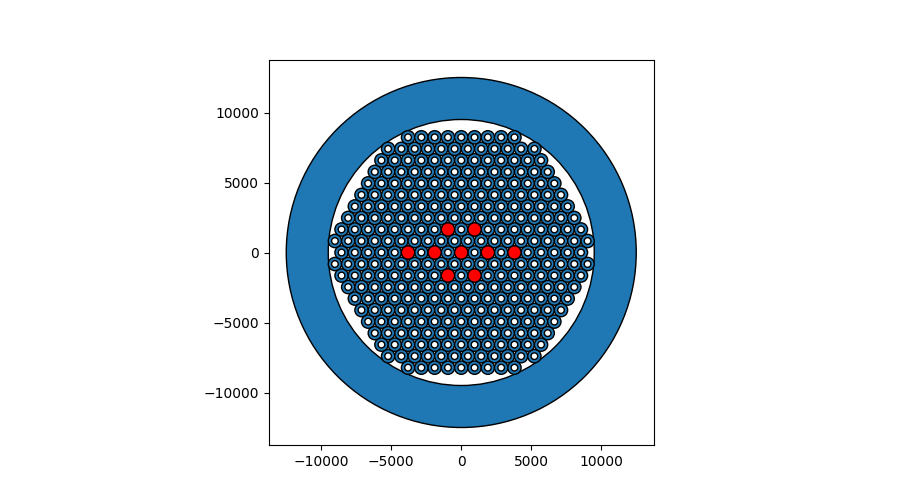

In [28]:
pcfStack.choose_jacket_tube(10_000,3_500)
pcfStack.choose_stack_tube(25_000, 19_000)
pcfStack.scale_lattice_to_stack_size()
pcfStack.show_stack_design()